### This notebook grabs the initial conditions created from JP output (by horizontal interpolation to our wcvi grid) and interpolates them to the NEMO depths obtained from the mesh_mask.nc 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from salishsea_tools import (nc_tools, gsw_calls,viz_tools)

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
# Specify the IC file name after horizontal interp to wcvi grid

IC_file = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc')



#### JP model output has the salinity in PSU (practical salinity), we would want that to be in Reference Salinity (SR) {corrected not Absolute Salinity (SA)}; to this extent we call the gsw call matlab wrapper; also JP has his tempertaure in Potential Temperature, we need to convert that to Conservative temperature

In [3]:
votemper_PT = IC_file.variables['votemper'][0,...];
vosaline_PSU = IC_file.variables['vosaline'][0,...];
lat = IC_file.variables['nav_lat'][:];
lon = IC_file.variables['nav_lon'][:];

# get the depths that JP had in his model output
depth = IC_file.variables['deptht'][:];
z = np.multiply(depth[:],-1);


print(votemper_PT.shape, z.shape, lat.shape)

(50, 100, 70) (50,) (100, 70)


In [4]:
z

array([ -4.94025379e-01,  -1.54137540e+00,  -2.64566851e+00,
        -3.81949472e+00,  -5.07822371e+00,  -6.44061422e+00,
        -7.92956018e+00,  -9.57299709e+00,  -1.14050026e+01,
        -1.34671383e+01,  -1.58100729e+01,  -1.84955597e+01,
        -2.15988159e+01,  -2.52114086e+01,  -2.94447289e+01,
        -3.44341545e+01,  -4.03440514e+01,  -4.73736877e+01,
        -5.57642899e+01,  -6.58072739e+01,  -7.78538513e+01,
        -9.23260727e+01,  -1.09729279e+02,  -1.30665985e+02,
        -1.55850723e+02,  -1.86125565e+02,  -2.22475174e+02,
        -2.66040253e+02,  -3.18127441e+02,  -3.80213013e+02,
        -4.53937744e+02,  -5.41088928e+02,  -6.43566833e+02,
        -7.63333069e+02,  -9.02339294e+02,  -1.06243970e+03,
        -1.24529114e+03,  -1.45225098e+03,  -1.68428442e+03,
        -1.94189343e+03,  -2.22507788e+03,  -2.53333618e+03,
        -2.86570264e+03,  -3.22082031e+03,  -3.59703198e+03,
        -3.99248389e+03,  -4.40522412e+03,  -4.83329053e+03,
        -5.27478418e+03,

In [5]:
vosaline_PSU[:,0,0]

array([ 32.47419739,  32.47340012,  32.47235107,  32.47062302,
        32.46957397,  32.46912384,  32.46870422,  32.46790314,
        32.46697617,  32.46654892,  32.46634293,  32.46618652,
        32.46605301,  32.46588898,  32.46588516,  32.46623993,
        32.46850967,  32.47960663,  32.52178955,  32.63602448,
        32.85181808,  33.1221199 ,  33.38578796,  33.65309525,
        33.81709671,  33.93756485,  34.00150681,  34.03875351,
        34.05470276,  34.05655289,  34.07886887,  34.13459396,
        34.20362854,  34.26293945,  34.33264542,  34.39530182,
        34.45331573,  34.49530029,  34.53695297,  34.5798111 ,
        34.62248993,  34.63830566,  34.64125443,  34.64125443,
        34.64125443,  34.64125443,  34.64125443,  34.64125443,
        34.64125443,  34.64125443], dtype=float32)

In [6]:
#for i,j in enumerate(z):
#    print(i)


#pressure = np.zeros(z.shape);
#for i,j in enumerate(z):
#    pressure[i] = gsw_calls.generic_gsw_caller('gsw_p_from_z.m',[z[i],np.mean(lat)]);
#votemper_SA = gsw_calls.generic_gsw_caller('gsw_SA_from_SP', [[SP,pressure,lon,lat]]);


pressure = np.zeros(z.shape);
lats = np.zeros(pressure.shape);
lons = np.zeros(pressure.shape);
lats[:] = np.mean(lat);
lons[:] = np.mean(lon);


vosaline_SA = np.zeros(vosaline_PSU.shape);
vosaline_RS = np.zeros(vosaline_PSU.shape);
votemper_CT = np.zeros(votemper_PT.shape);

pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);
for i,j in enumerate(vosaline_SA[:,...]):
    vosaline_SA[i,...] = gsw_calls.generic_gsw_caller('gsw_SA_from_SP', [vosaline_PSU[i,...],pressure[i],lons[i],lats[i]]);

vosaline_RS[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_PSU[:]]);
votemper_CT[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_SA[:], votemper_PT[:]]);


In [7]:
print(vosaline_RS.shape, vosaline_SA.shape, votemper_CT.shape)

(50, 100, 70) (50, 100, 70) (50, 100, 70)


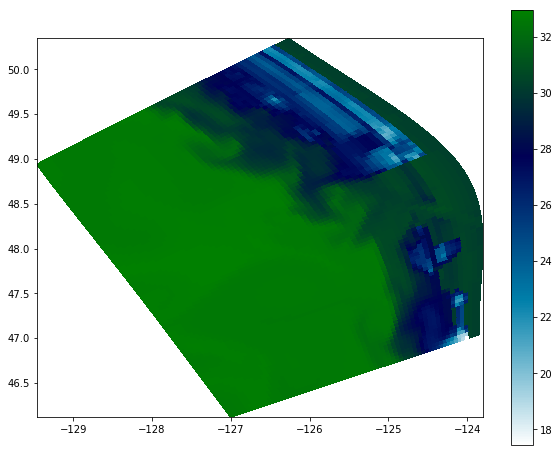

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(lon, lat, vosaline_RS[0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

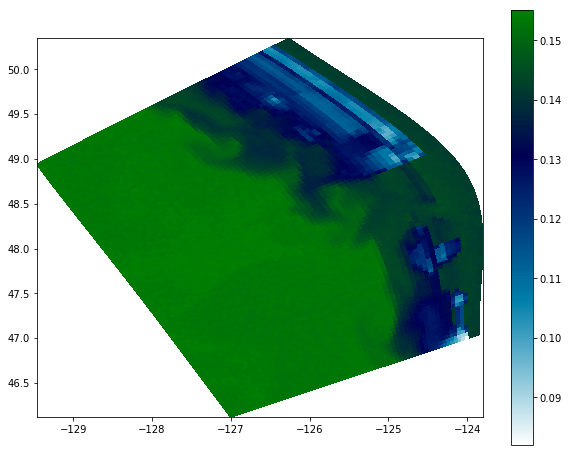

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(lon, lat ,(vosaline_RS[0,...] - vosaline_PSU[0,...]), cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [10]:
pressure

array([  4.98210000e-01,   1.55440000e+00,   2.66810000e+00,
         3.85190000e+00,   5.12130000e+00,   6.49530000e+00,
         7.99690000e+00,   9.65440000e+00,   1.15020000e+01,
         1.35820000e+01,   1.59450000e+01,   1.86530000e+01,
         2.17830000e+01,   2.54270000e+01,   2.96960000e+01,
         3.47290000e+01,   4.06900000e+01,   4.77810000e+01,
         5.62450000e+01,   6.63760000e+01,   7.85290000e+01,
         9.31300000e+01,   1.10690000e+02,   1.31820000e+02,
         1.57230000e+02,   1.87790000e+02,   2.24480000e+02,
         2.68470000e+02,   3.21070000e+02,   3.83790000e+02,
         4.58290000e+02,   5.46400000e+02,   6.50040000e+02,
         7.71240000e+02,   9.11990000e+02,   1.07420000e+03,
         1.25970000e+03,   1.46970000e+03,   1.70550000e+03,
         1.96760000e+03,   2.25600000e+03,   2.57040000e+03,
         2.91000000e+03,   3.27330000e+03,   3.65880000e+03,
         4.06480000e+03,   4.48930000e+03,   4.93040000e+03,
         5.38620000e+03,

In [11]:
IC_file.variables

OrderedDict([('nav_lat', <class 'netCDF4._netCDF4.Variable'>
              float32 nav_lat(yb, xb)
                  long_name: Latitude
                  units: degrees_north
              unlimited dimensions: 
              current shape = (100, 70)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('nav_lon', <class 'netCDF4._netCDF4.Variable'>
              float32 nav_lon(yb, xb)
                  long_name: Longitude
                  units: degrees_east
              unlimited dimensions: 
              current shape = (100, 70)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('deptht', <class 'netCDF4._netCDF4.Variable'>
              float32 deptht(deptht)
                  long_name: Vertical T Levels
                  units: m
                  positive: down
              unlimited dimensions: 
              current shape = (50,)
              filling on, default _FillValue of 9.9692099683868

#### The plots shows that the gsw calls worked out well, now we proceed to make a function that would interpolate the IC from JP depth levels to our depth levels which we are going to import from a mesh mask


#### We are going to use the mesh_mask which I generated recently using the parameters which I figured out

In [12]:
mask = nc.Dataset('/ocean/ssahu/CANYONS/Runs/trial_run_mesh_mask_gen/mesh_mask.nc')


#mask = nc.Dataset('/ocean/ssahu/CANYONS/Results/Westcoast_attempt17_generate_mask_80_levels/mesh_mask.nc')

NEMO_depth = mask.variables['gdept_0'][0,:,0,0];
tmask_WCVI = mask.variables['tmask'][:];

print(NEMO_depth.shape, NEMO_depth)

(27,) [   14.75075722    24.42877769    34.46412659    45.19285583    57.26233673
    71.90678406    91.43279266   119.99002075   164.52903748   235.26014709
   344.00537109   499.3053894    701.16015625   941.02905273  1207.08996582
  1489.1328125   1780.20678711  2076.16235352  2374.69287109  2674.56420898
  2975.12866211  3276.05078125  3577.15649414  3878.35668945  4179.60546875
  4480.87939453  4782.16601562]


In [13]:
vosaline_SA.shape[1]

100

In [14]:
salinity_function = interp1d(depth, vosaline_RS, axis = 0, bounds_error=False, fill_value='extrapolate');
temperature_function = interp1d(depth, votemper_CT, axis = 0, bounds_error=False, fill_value='extrapolate');

In [15]:
vosaline_NEMO = np.zeros((NEMO_depth.shape[0], vosaline_RS.shape[1], vosaline_RS.shape[2]));
votemper_NEMO = np.zeros((NEMO_depth.shape[0], vosaline_RS.shape[1], vosaline_RS.shape[2]));
for indx in np.arange(NEMO_depth.shape[0]):
#for y in np.arange(vosaline.shape[1]):
#for x in np.arange(vosaline.shape[2]):
    vosaline_NEMO[indx,...] = salinity_function(NEMO_depth[indx]);
    votemper_NEMO[indx,...] = temperature_function(NEMO_depth[indx]);

In [16]:
vosaline_NEMO.shape, votemper_NEMO.shape

((27, 100, 70), (27, 100, 70))

In [17]:
print(vosaline_NEMO[12,...], NEMO_depth[12])

[[ 34.39385287  34.39333375  34.39429551 ...,  33.976       33.928       33.94      ]
 [ 34.39685287  34.39681463  34.39681463 ...,  33.976       33.928       33.939     ]
 [ 34.40085287  34.40033375  34.39933375 ...,  33.976       33.928       33.939     ]
 ..., 
 [ 34.38106608  34.38106608  34.38206608 ...,  33.976       33.923       33.938     ]
 [ 34.38106608  34.38154697  34.38206608 ...,  33.976       33.924       33.939     ]
 [ 34.38206608  34.38254697  34.38306608 ...,  33.976       33.924       33.939     ]] 701.16


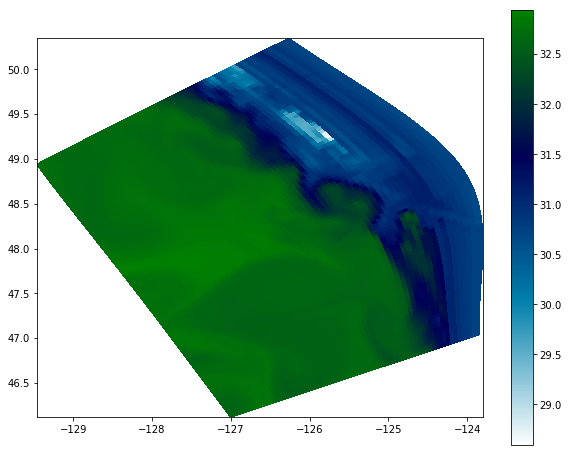

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(lon, lat, vosaline_NEMO[0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [19]:
tmask_WCVI[0,...].shape, vosaline_NEMO.shape

((27, 100, 70), (27, 100, 70))

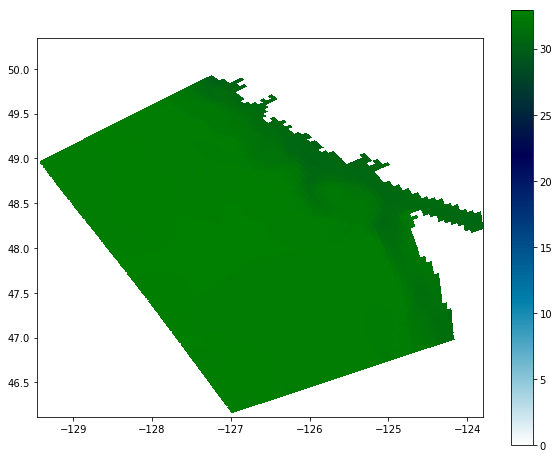

In [20]:
### Plot after multiplying the tmask with the tmask of WCVI to show the land masking is proper or not\
### we wont be masking the input data to begin with rather we will let NEMO mask it by itself

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(lon, lat, np.multiply(vosaline_NEMO[0,...],tmask_WCVI[0,0,...]), cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

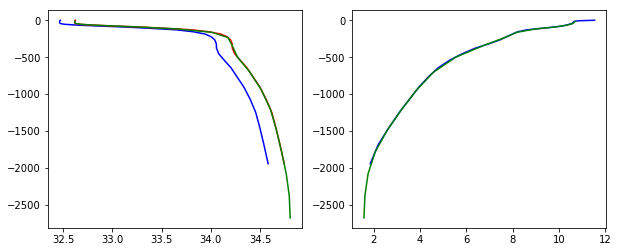

In [21]:
# Let's see how well our interpolation does vertically with the vertical profile tests at the same point of our domain


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(vosaline_PSU[:40,0,0],z[:40], '-b',vosaline_RS[:40,0,0], z[:40], '-r', vosaline_NEMO[:20,0,0], -NEMO_depth[:20], '-g')

plt.subplot(1,2,2)
plt.plot(votemper_PT[:40,0,0],z[:40], '-b', votemper_NEMO[:20,0,0], -NEMO_depth[:20], '-g')

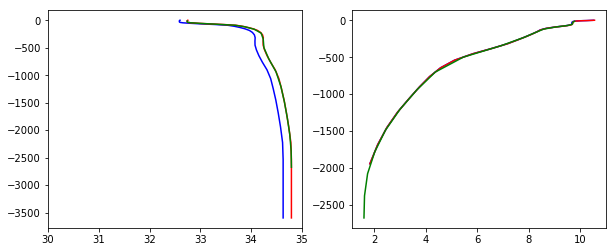

In [22]:
#Checking at a different point just to be sure

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(vosaline_PSU[:45,50,0],z[:45], '-b',vosaline_RS[:45,50,0], z[:45], '-r', vosaline_NEMO[:20,50,0], -NEMO_depth[:20], '-g')
plt.xlim((30,35))

plt.subplot(1,2,2)
plt.plot(votemper_PT[:40,50,0],z[:40], '-b', votemper_CT[:40,50,0],z[:40], '-r', votemper_NEMO[:20,50,0], -NEMO_depth[:20], '-g')

#### Now since we have the data what we need we can proceed to write the initial conditions for our NEMO model

In [23]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 

In [24]:
glamt_wcvi.shape

(100, 70)

In [25]:
np.min(vosaline_NEMO)

28.083754618000647

### Now let us fill up the holes in the IC file

In [26]:
for i,j in enumerate(votemper_NEMO[:,...]):
    for p,q in enumerate(votemper_NEMO[i,:,...]):
        for l,m in enumerate(votemper_NEMO[i,p,:]):
            if votemper_NEMO[i,p,l] == 0:
                votemper_NEMO[i,p,l] = votemper_NEMO[i-1,p,l]
            else:
                continue

                
for i,j in enumerate(vosaline_NEMO[:,...]):
    for p,q in enumerate(vosaline_NEMO[i,:,...]):
        for l,m in enumerate(vosaline_NEMO[i,p,:]):
            if vosaline_NEMO[i,p,l] == 0:
                vosaline_NEMO[i,p,l] = vosaline_NEMO[i-1,p,l]
            else:
                continue


In [27]:
np.min(vosaline_NEMO)

28.083754618000647

In [28]:
file_temp = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_temperature_salinity_nomask_JP.nc', 'w', zlib=True)
# dataset attributes
nc_tools.init_dataset_attrs(
    file_temp, 
    title='Temperature and salinity Initial Condition', 
    notebook_name='Making_IC_from_JP', 
    nc_filepath='/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_temperature_salinity_nomask_JP.nc',
    comment='Temperature and salinity from JP Model, preliminary_grid; used at all grid points and interpolated vertically')

file_temp.createDimension('xb', votemper_NEMO.shape[2]);
file_temp.createDimension('yb', votemper_NEMO.shape[1]);
file_temp.createDimension('deptht', votemper_NEMO.shape[0]);
file_temp.createDimension('time_counter', None);


nav_lat = file_temp.createVariable('nav_lat', 'float32', ('yb','xb'));
nav_lat.long_name = 'Latitude';
nav_lat.units = 'degrees_north';


nav_lon = file_temp.createVariable('nav_lon', 'float32', ('yb','xb'));
nav_lon.long_name = 'Longitude';
nav_lon.units = 'degrees_east';


deptht = file_temp.createVariable('deptht', 'float32', ('deptht'));
deptht.long_name = 'Vertical T Levels';
deptht.units = 'm';
deptht.positive = 'down';


time_counter = file_temp.createVariable('time_counter', 'float32', ('time_counter'));
time_counter.units = 's';
time_counter.long_name = 'time';
time_counter.calendar = 'noleap';


votemper = file_temp.createVariable('votemper', 'float32', ('time_counter','deptht','yb','xb'));
#votemper = file_temp.createVariable('votemper', 'float32', ('deptht','yb','xb'));
votemper.units = 'degC'
votemper.long_name = 'Conservative Temperature (CT)';
votemper.grid = 'WCVI';


vosaline = file_temp.createVariable('vosaline', 'float32', ('time_counter','deptht','yb','xb'));
#vosaline = file_temp.createVariable('vosaline', 'float32', ('deptht','yb','xb'));
vosaline.units = 'g/Kg';
vosaline.long_name = 'Reference Salinity (SR)';
vosaline.grid = 'WCVI';




nav_lat[:] = gphit_wcvi[:];
nav_lon[:] = glamt_wcvi[:];
deptht[:] = NEMO_depth[:];
time_counter[0] = 1;
votemper[0,...] = votemper_NEMO[:]
vosaline[0,...]= vosaline_NEMO[:]

file_temp.close()



file format: NETCDF4
Conventions: CF-1.6
title: Temperature and salinity Initial Condition
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/canyonsubc/wcvi/src/tip/grid/Making_IC_from_JP.ipynb
references: REQUIRED
history: [2017-08-29 15:16:57] Created netCDF4 zlib=True dataset.
comment: Temperature and salinity from JP Model, preliminary_grid; used at all grid points and interpolated vertically


In [29]:
init_file = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_temperature_salinity_nomask_JP.nc')

nc_tools.show_dimensions(init_file);
nc_tools.show_variables(init_file);


<class 'netCDF4._netCDF4.Dimension'>: name = 'xb', size = 70

<class 'netCDF4._netCDF4.Dimension'>: name = 'yb', size = 100

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 27

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

odict_keys(['nav_lat', 'nav_lon', 'deptht', 'time_counter', 'votemper', 'vosaline'])


In [30]:
votemper_IC = init_file.variables['votemper'][:];

In [31]:
votemper_IC[0,:,15,20]

array([ 10.42427635,  10.33076572,  10.29894447,  10.28041267,
        10.26674557,  10.25834179,  10.02456665,   9.05784988,
         8.13713646,   7.56082487,   6.42777586,   5.17705107,
         4.25172186,   3.53922606,   2.93445396,   2.38302422,
         1.98613501,   1.73385406,   1.63066149,   1.61619997,
         1.61619997,   1.61619997,   1.61619997,   1.61619997,
         1.61619997,   1.61619997,   1.61619997], dtype=float32)